#데이터 분석

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
import pandas as pd
import numpy as np

ar = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/articles.csv/articles.csv')
cu = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/customers.csv/customers.csv')
sub = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/sample_submission.csv/sample_submission.csv')
tr = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/transactions_train.csv/transactions_train.csv')

In [ ]:
ar.info()
cu.info()
tr.info()

In [ ]:
# 날짜 처리
tr['t_dat'] = pd.to_datetime(tr['t_dat'])

##상위 유저 비율에 따른 누적 구매 기여도

In [ ]:
tr.groupby('customer_id').size().reset_index(name='purchase_count').sort_values(by='purchase_count', ascending=False).head()

In [ ]:
# 시각화를 위해 누적 비율을 포함한 DataFrame 생성
user_purchase_counts = tr.groupby('customer_id').size().reset_index(name='purchase_count')
user_purchase_counts = user_purchase_counts.sort_values(by='purchase_count', ascending=False)

# 누적 구매 기여도 계산
user_purchase_counts['cumulative_purchase_count'] = user_purchase_counts['purchase_count'].cumsum()
total_purchases = user_purchase_counts['purchase_count'].sum()
user_purchase_counts['cumulative_contribution'] = (user_purchase_counts['cumulative_purchase_count'] / total_purchases) * 100

# 누적 사용자 비율 계산
user_purchase_counts['user_cumulative_percentage'] = (np.arange(len(user_purchase_counts)) + 1) / len(user_purchase_counts) * 100

# 시각화
plt.figure(figsize=(12, 8))
sns.lineplot(x='user_cumulative_percentage', y='cumulative_contribution', data=user_purchase_counts)

# 그래프에 주요 포인트 추가 (예: 상위 1%, 5%, 10%, 20%, 50%)
for percent in [1, 5, 10, 20, 50]:
    if percent <= 100:
        num_users_at_percent = int(len(user_purchase_counts) * (percent / 100))
        # Ensure index is within bounds
        if num_users_at_percent > 0 and num_users_at_percent <= len(user_purchase_counts):
            # Adjust index for 0-based indexing
            user_index = num_users_at_percent - 1 if num_users_at_percent > 0 else 0
            contribution_at_percent = user_purchase_counts['cumulative_contribution'].iloc[user_index]
            plt.plot(percent, contribution_at_percent, 'ro') # Mark the point
            plt.text(percent, contribution_at_percent, f'{contribution_at_percent:.1f}%', fontsize=10, ha='left')

plt.title('Cumulative Purchase Contribution by User Percentage', fontsize=16)
plt.xlabel('Percentage of Users (sorted by purchase count, from top)', fontsize=13)
plt.ylabel('Cumulative Purchase Contribution (%)', fontsize=13)
plt.grid(True)
plt.xlim(0, 100) # Set x-axis limit to 0-100%
plt.ylim(0, 100) # Set y-axis limit to 0-100%
plt.show()

# 상위 몇 프로 유저의 누적 기여도 출력
for percent in [1, 5, 10, 20, 50]:
    if percent <= 100:
        num_users_at_percent = int(len(user_purchase_counts) * (percent / 100))
         # Ensure index is within bounds
        if num_users_at_percent > 0 and num_users_at_percent <= len(user_purchase_counts):
            # Adjust index for 0-based indexing
            user_index = num_users_at_percent - 1 if num_users_at_percent > 0 else 0
            contribution_at_percent = user_purchase_counts['cumulative_contribution'].iloc[user_index]
            print(f"상위 {percent}% 유저는 전체 구매의 {contribution_at_percent:.2f}%를 기여합니다.")

##연도-월별 판매 분석

In [ ]:
print("가장 빠른 날짜:", tr['t_dat'].min())
print("가장 느린 날짜:", tr['t_dat'].max())

In [ ]:
#전체 판매 수익(2018.9~2020.9 총 2년간)
tr['year_month'] = tr['t_dat'].dt.to_period('M').astype(str)
price_by_month = tr.groupby(['year_month'])[['price']].sum().reset_index()
price_by_month.sort_values(by='price', ascending=False).head()
fig = px.line(data_frame=price_by_month, x="year_month", y="price")
fig.show()

In [ ]:
# 연도별 판매 수익
tr['year'] = tr['t_dat'].dt.year
price_by_year = tr.groupby(['year'])[['price']].sum().reset_index()
print("\n연도별 판매 수익:")
print(price_by_year)

fig_year = px.line(data_frame=price_by_year, x="year", y="price", title="연도별 판매 수익")
fig_year.show()

In [ ]:
# 월별 평균 판매 수익
tr['month'] = tr['t_dat'].dt.month
price_by_month_avg = tr.groupby(['month'])[['price']].mean().reset_index()
print("\n월별 평균 판매 수익:")
print(price_by_month_avg)

fig_month_avg = px.line(data_frame=price_by_month_avg, x="month", y="price", title="월별 평균 판매 수익")
fig_month_avg.update_xaxes(dtick=1)
fig_month_avg.show()

In [ ]:
# 월별 구매 빈도 계산
monthly_purchases = tr.groupby('month').size().reset_index(name='purchase_count')
print("\n월별 구매 빈도:")
print(monthly_purchases)

# 월별 구매 빈도
fig_monthly_px = px.line(data_frame=monthly_purchases, x="month", y="purchase_count", title="월별 구매 빈도")
fig_monthly_px.update_xaxes(dtick=1)
fig_monthly_px.show()

##히트상품,지난주 인기상품

In [ ]:
from os.path import exists
import matplotlib.pyplot as plt
import cv2

히트 상품

In [ ]:
# 전체 판매량 계산
hit = tr["article_id"].value_counts().reset_index()
hit.columns = ["article_id", "sales"]

# 상위 1000개 제외 (기본템 제외)
hit = hit.iloc[1000:].reset_index(drop=True)

# 상위 10%를 히트 상품으로 간주
threshold = hit["sales"].quantile(0.90)
hit["hit"] = (hit["sales"] >= threshold).astype(int)

# 최종 히트 상품 추출
hit = hit[hit["hit"] == 1].reset_index(drop=True)

# 확인
print(f"히트상품 개수: {len(hit)}개")
print("히트상품 예시:",hit.head())

In [ ]:
#시각화
BASE = '/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/images'
hit_article_ids = hit['article_id'].tolist()

plt.figure(figsize=(20, 4))  # 전체 가로 사이즈 설정

shown = 0;idx = 0
top_n = 5  # 원하는 이미지 개수

while shown < top_n and idx < len(hit_article_ids):
    article_id = hit_article_ids[idx]
    img_path = BASE + '/0' + str(article_id)[:2] + '/0' + str(article_id) + '.jpg'

    if exists(img_path):
        img = cv2.imread(img_path)[:, :, ::-1]
        plt.subplot(1, top_n, shown + 1)
        plt.imshow(img)
        plt.title(f'{article_id}', fontsize=10)
        plt.axis('off')
        shown += 1
    else:
        print(f"Image not found for article ID: {article_id}")

    idx += 1

plt.tight_layout()
plt.show()

연령대별 히트상품

In [ ]:
# 연령대 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(data=cu, x='age', bins=30, kde=True)
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.show()

In [ ]:
# 연령 정보 결합
customer_transactions = tr.merge(cu[['customer_id', 'age']], on='customer_id', how='left')

# 연령대 분류 (10세 단위: 0-9, 10-19, ..., 90-99)
bins = list(range(0, 101, 10))
labels = [f'{i}-{i+9}' for i in range(0, 100, 10)]
customer_transactions['age_group'] = pd.cut(customer_transactions['age'], bins=bins, labels=labels, right=False)

# 전체 판매량 기준 상위 1000개 상품 ID 추출 (기본템)
overall_top1000 = tr["article_id"].value_counts().head(1000).index

# 연령대별 x 상품별 판매량 계산
age_group_sales = customer_transactions.groupby(['age_group', 'article_id']).size().reset_index(name='sales_count')

# 상위 1000개 상품 제거(기본템 제외)
age_group_sales = age_group_sales[~age_group_sales["article_id"].isin(overall_top1000)].reset_index(drop=True)

# 연령대별 상위 3개 추출
top_n = 3
hit_items_by_age_group = age_group_sales.groupby("age_group").apply(lambda x: x.nlargest(top_n, "sales_count")).reset_index(drop=True)

# 시각화
BASE = '/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/images'

for age_group in hit_items_by_age_group['age_group'].unique():
    print(f"\n연령대: {age_group} - 상위 {top_n}개 히트 상품:")

    # 이 연령대의 히트 상품 중 판매량 0 초과만 필터링
    age_group_df = hit_items_by_age_group[
        (hit_items_by_age_group['age_group'] == age_group) &
        (hit_items_by_age_group['sales_count'] > 0)
    ]

    print(age_group_df[['article_id', 'sales_count']])
    age_group_article_ids = age_group_df['article_id'].tolist()

    # 시각화
    plt.figure(figsize=(20, 4))
    shown = 0
    for article_id in age_group_article_ids:
        img_path = BASE + '/0' + str(article_id)[:2] + '/0' + str(article_id) + '.jpg'
        if exists(img_path):
            img = cv2.imread(img_path)[:, :, ::-1]
            if shown < top_n:
                plt.subplot(1, top_n, shown + 1)
                plt.imshow(img)
                plt.title(f'{article_id}', fontsize=10)
                plt.axis('off')
                shown += 1
        else:
            print(f"Image not found for article ID: {article_id}")
            if shown < top_n:
                plt.subplot(1, top_n, shown + 1)
                plt.text(0.5, 0.5, f'No Image\n{article_id}', horizontalalignment='center',
                         verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
                plt.axis('off')
                shown += 1

    plt.tight_layout()
    plt.show()

최근 1주일 인기상품

In [ ]:
#최근 1주일
popular_1week = tr[tr['t_dat'] >= pd.to_datetime('2020-09-16')]

# 인기 있는 상위 article_id 추출
popular_items = popular_1week['article_id'].value_counts().index.astype(str)

# 확인
print("최근 1주일 인기상품 예시:", popular_items[:5])

In [ ]:
#시각화
BASE = '/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/images'

plt.figure(figsize=(20, 4))  # 전체 가로 사이즈 설정

shown = 0
for i, article_id in enumerate(popular_items[:5]):  # 상위 5개만 시각화
    img_path = BASE + '/0' + str(article_id)[:2] + '/0' + str(article_id) + '.jpg'
    if exists(img_path):
        img = cv2.imread(img_path)[:, :, ::-1]
        plt.subplot(1, 5, shown + 1)
        plt.imshow(img)
        plt.title(f'{article_id}', fontsize=10)
        plt.axis('off')
        shown += 1

plt.tight_layout()
plt.show()

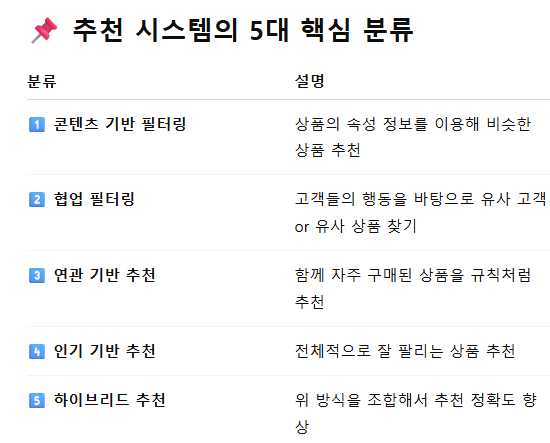

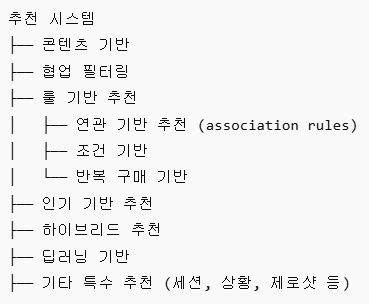

#콘텐츠 기반 추천시스템

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
ar = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/articles.csv/articles.csv')
cu = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/customers.csv/customers.csv')
sub = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/sample_submission.csv/sample_submission.csv')
tr = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/transactions_train.csv/transactions_train.csv')

상품 콘텐츠 벡터화 (TF-IDF + 범주형 → PCA)

In [ ]:
# 필요한 컬럼 정제
ar_subset = ar[["article_id", "detail_desc", "product_group_name","colour_group_name", "graphical_appearance_name"]].dropna()

# TF-IDF (텍스트) + One-Hot (카테고리)
tfidf = TfidfVectorizer(stop_words='english', max_features=300)
tfidf_matrix = tfidf.fit_transform(ar_subset["detail_desc"])

encoder = OneHotEncoder(sparse_output=False)
cat_features = encoder.fit_transform(ar_subset[["product_group_name", "colour_group_name", "graphical_appearance_name"]])

# 통합 및 차원 축소
features = np.hstack((tfidf_matrix.toarray(), cat_features))
pca = PCA(n_components=50, random_state=42)
reduced_features = pca.fit_transform(features)

고객 구매 이력 기반 함수 생성

In [ ]:
ar_ids = ar_subset["article_id"].tolist()
ar_id_to_idx = {aid: idx for idx, aid in enumerate(ar_ids)}

# 고객 → 최근 구매한 article_id 목록
def recommend_by_profile(customer_id, top_n=12):
    history = tr[tr["customer_id"] == customer_id]["article_id"].tolist()
    idxs = [ar_id_to_idx[aid] for aid in history if aid in ar_id_to_idx]

    if not idxs:
        return []

    # 평균 벡터 → 고객 취향 벡터
    profile_vector = np.mean(reduced_features[idxs], axis=0).reshape(1, -1)

    # 유사도 계산
    sim_scores = cosine_similarity(profile_vector, reduced_features)[0]
    ranked_idxs = np.argsort(sim_scores)[::-1]

    # 이미 구매한 상품 제외하고 상위 n개 추출
    recommended = [ar_ids[i] for i in ranked_idxs if ar_ids[i] not in history][:top_n]
    return recommended

예시 실행

In [ ]:
example_customer = tr["customer_id"].iloc[100]
print(f"고객 ID: {example_customer}\n추천 결과:",recommend_by_profile(example_customer))

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# 경로 설정
BASE = '/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/images'

# 추천 결과 (예시)
article_ids = recommend_by_profile(example_customer)

# 시각화
plt.figure(figsize=(20, 4))  # 가로 크기 설정

shown = 0
idx = 0
top_n = 5  # 출력할 이미지 개수

while shown < top_n and idx < len(article_ids):
    article_id = article_ids[idx]
    img_path = os.path.join(BASE, '0' + str(article_id)[:2], '0' + str(article_id) + '.jpg')

    if os.path.exists(img_path):
        img = cv2.imread(img_path)[:, :, ::-1]  # BGR -> RGB 변환
        plt.subplot(1, top_n, shown + 1)
        plt.imshow(img)
        plt.title(f'{article_id}', fontsize=10)
        plt.axis('off')
        shown += 1
    else:
        print(f"Image not found for article ID: {article_id}")

    idx += 1

plt.tight_layout()
plt.show()

#베이스라인 - 잠재요인 협업필터링(ALS)

In [ ]:
!pip install scipy==1.9.3
!pip install implicit==0.6.1

In [ ]:
!pip install implicit

In [ ]:
import os; os.environ['OPENBLAS_NUM_THREADS']='1'
import numpy as np
import pandas as pd
import implicit
import scipy
from scipy.sparse import coo_matrix,csr_matrix
from implicit.evaluation import mean_average_precision_at_k
from implicit.als import AlternatingLeastSquares

In [ ]:
print("implicit version:", implicit.__version__)
print("scipy version:", scipy.__version__)

In [ ]:
ar = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/articles.csv/articles.csv')
cu = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/customers.csv/customers.csv')
sub = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/sample_submission.csv/sample_submission.csv')
tr = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/transactions_train.csv/transactions_train.csv')

In [ ]:
#날짜 처리
tr['t_dat'] = pd.to_datetime(tr['t_dat'])

#마지막 날짜
print(tr['t_dat'].max())

# 최근 한달 데이터로만 진행
tr = tr[(tr['t_dat'] >= '2020-08-22')]
tr.shape

In [ ]:
# 고객과 상품의 고유 ID 리스트 추출
ALL_USERS = cu['customer_id'].unique().tolist()
ALL_ITEMS = ar['article_id'].unique().tolist()

# 고객과 상품의 정수 인덱스 생성 (순서대로 0부터)
user_ids = dict(enumerate(ALL_USERS))
item_ids = dict(enumerate(ALL_ITEMS))

# 역매핑: 실제ID -> 인덱스(map용)
user_map = {u: uidx for uidx, u in user_ids.items()}
item_map = {i: iidx for iidx, i in item_ids.items()}

# 트랜잭션에 고객, 상품의 정수 인덱스를 컬럼으로 추가
tr['user_id'] = tr['customer_id'].map(user_map)
tr['item_id'] = tr['article_id'].map(item_map)

In [ ]:
#coo행렬 생성 함수
def to_user_item_coo(df):
    row = df['user_id'].values
    col = df['item_id'].values
    data = np.ones(df.shape[0])
    coo = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
    return coo

In [ ]:
# 최근 일주일 데이터를 검증 데이터로 생성
validation_cut = tr['t_dat'].max() - pd.Timedelta(7)
tr_train = tr[tr['t_dat'] < validation_cut]
tr_val = tr[tr['t_dat'] >= validation_cut]

In [ ]:
#tran,validation 데이터로 coo,csr 행렬 생성
coo_train = to_user_item_coo(tr_train)
coo_val = to_user_item_coo(tr_val)

csr_train = coo_train.tocsr()
csr_val = coo_val.tocsr()

하이퍼파라미터 튜닝

In [ ]:
best_map12 = 0
for factors in [60, 100, 200, 500]:
    for iterations in [3, 15, 20]:
        for regularization in [0.01]:
            model = implicit.als.AlternatingLeastSquares(factors=factors,
                                                         iterations=iterations,
                                                         regularization=regularization,
                                                         random_state=77)
            model.fit(coo_train, show_progress=False)
            map12 = mean_average_precision_at_k(model, csr_train, csr_val, K=12, show_progress=False, num_threads=4)
            if map12 > best_map12:
                best_map12 = map12
                best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@12 found. Updating: {best_params}")

In [ ]:
best_params

전체 데이터(최근 1달치 데이터)로 모델링

In [ ]:
#최근 한달치 전체 데이터로 coo,csr 행렬 생성
coo_train = to_user_item_coo(tr)
csr_train = coo_train.tocsr()

In [ ]:
#best_params로 모델 학습
model = implicit.als.AlternatingLeastSquares(factors=500,
                                                 iterations=3 ,
                                                 regularization=0.01,
                                                 random_state=77)
model.fit(coo_train, show_progress=True)

submission

In [ ]:
# 2020-09-16 이후 데이터 필터링
popular_1week = tr[tr['t_dat'] >= pd.to_datetime('2020-09-16')]

# 인기 있는 상위 12개 article_id 추출
top12 = popular_1week['article_id'].value_counts().index.astype(str)[:12]

print("Last week's top 12 popular items:")
print(top12)

In [ ]:
def submit(model, csr_train):
    preds = []
    batch_size = 2000
    to_generate = np.arange(len(ALL_USERS))
    for startidx in range(0, len(to_generate), batch_size):
        batch = to_generate[startidx : startidx + batch_size]
        ids, scores = model.recommend(batch, csr_train[batch], N=12, filter_already_liked_items=False)
        for i, userid in enumerate(batch):
            customer_id = user_ids[userid]
            # 구매이력이 없는 유저는 최근 일주일 인기상품으로 추천
            if np.all(model.user_factors[userid] == 0):
                article_ids = top12
            else:
                user_items = ids[i]
                article_ids = [str(item_ids[item_id]) for item_id in user_items]
            preds.append((customer_id, ' '.join(article_ids)))
    df_preds = pd.DataFrame(preds, columns=['customer_id', 'prediction'])
    return df_preds

In [ ]:
df_preds = submit(model, csr_train)

In [ ]:
def add_zero_to_article_ids(pred):
    if pd.isna(pred):  # NaN 예외 처리
        return pred
    return ' '.join(['0' + aid if not aid.startswith('0') else aid for aid in pred.split()])

df_preds['prediction'] = df_preds['prediction'].apply(add_zero_to_article_ids)

In [ ]:
df_preds.head()

In [ ]:
df_preds.to_csv("submission.csv",index=False)

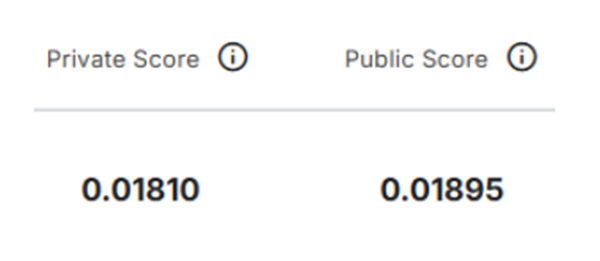

# 성능개선

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np

ar = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/articles.csv/articles.csv')
cu = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/customers.csv/customers.csv')
sub = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/sample_submission.csv/sample_submission.csv')
tr = pd.read_csv('/content/drive/MyDrive/competition/H&M 개인 맞춤 패션 추천/transactions_train.csv/transactions_train.csv')

In [ ]:
#원래 데이터 보존을 위해
tr1=tr.copy()

memory 효율화를 위해 고객 ID와 상품 ID의 자료형을 처리

In [ ]:
# 컬럼 이름 공백 제거
tr1.columns = tr1.columns.str.strip()

#customer_id,article_id 처리
tr1['customer_id'] = tr1['customer_id'].astype(str).str[-16:].apply(lambda x: int(x, 16)).astype('int64')
tr1['article_id'] = tr1['article_id'].astype('int32')

#날짜 처리
tr1['t_dat'] = pd.to_datetime(tr1['t_dat'])

# 필요한 컬럼만 선택
tr1 = tr1[['t_dat', 'customer_id', 'article_id']]

고객별로 가장 최근의 구매일을 계산하고, 그로부터 6일 이내의 거래만을 필터링

In [ ]:
# 고객별로 가장 최근 구매 날짜 구하기
last_purchase = tr1.groupby('customer_id')['t_dat'].max().reset_index()
last_purchase.columns = ['customer_id', 'last_date']

# 원본 거래 데이터에 고객별 마지막 구매일 붙이기
tr1 = tr1.merge(last_purchase, on='customer_id', how='left')

# 각 거래가 마지막 구매일로부터 며칠 전인지 계산
tr1['days_ago'] = (tr1['last_date'] - tr1['t_dat']).dt.days

# 마지막 구매일로부터 6일 이내 거래만 남기기 (최근 7일)
tr1 = tr1[tr1['days_ago'] <= 6]

# 거래 수 확인
print("원래 거래 수:", len(tr))
print("최근 7일 이내 거래 수:", len(tr1))

##1. 고객이 자주 구매한 상품 추천

고객이 같은 상품을 몇 번 구매했는지 카운트 • 자주 사고, 최근에 산 상품 순으로 정렬 후 중복 제거

In [ ]:
# 고객이 같은 상품을 몇 번 샀는지 계산
purchase_count = tr1.groupby(['customer_id', 'article_id'])['t_dat'].count().reset_index()
purchase_count.columns = ['customer_id', 'article_id', 'num_purchases']  # 구매 횟수

# 원본 거래 데이터에 구매 횟수 정보 붙이기
tr1 = tr1.merge(purchase_count, on=['customer_id', 'article_id'], how='left')

# 많이 사고, 최근에 산 거래가 먼저 오도록 정렬
tr1 = tr1.sort_values(by=['num_purchases', 't_dat'], ascending=False)

# 고객이 같은 상품을 여러 번 샀다면 → 1건만 남기기 (가장 자주 & 최근 것)
tr1 = tr1.drop_duplicates(subset=['customer_id', 'article_id'])

tr1.head()

##2. 함께 자주 구매되는 상품 쌍(pairs) - 연관 기반 추천 시스템

상위 판매 아이템 중 1000~1032번쨰 아이템 기준으로,
 이 아이템을 산 고객들이 함께 산 다른 아이템 3개를 추출하여 연관 추천 쌍 생성

In [ ]:
# 필요한 컬럼만 선택
tr1 = tr1[['customer_id', 'article_id']]

# 상위 아이템 중 1000번째부터 1032번째까지 선택
# 너무 인기있는 상품은 다들 사서 연관성이 약하고 인기없는 상품은 샘플수 부족
vc = tr1['article_id'].value_counts()

pairs = {}
for j, i in enumerate(vc.index[1000:1032]):
    # i: 현재 기준 article_id
    # 이 상품을 구매한 고객들 찾기
    USERS = tr1[tr1['article_id'] == i]['customer_id'].unique()

    # 이 고객들이 구매한 다른 상품의 빈도 수 계산
    vc2 = tr1[(tr1['customer_id'].isin(USERS)) & (tr1['article_id'] != i)]['article_id'].value_counts()

    # 상위 3개 아이템 저장 (3개 미만일 경우 예외 처리 포함)
    pairs[i] = vc2.index[:3].tolist()

# 결과 확인 (예: 3개만 출력)
for k, v in list(pairs.items())[:3]:
    print(f"Item {k} frequently bought with: {v}")

상위 1000개를 제외한 상품들 중,
고객들이 함께 자주 구매한 연관 상품 3개씩을 뽑아
딕셔너리 pairs에 저장

In [ ]:
# 연관 상품 추천 딕셔너리 저장 및 불러오기
np.save('pairs_dict.npy', pairs)
pairs = np.load('pairs_dict.npy', allow_pickle=True).item()

# article_id를 기준으로 딕셔너리 매핑하여 새 column 생성
tr1['article_id2'] = tr1['article_id'].map(pairs)

# 연관상품 리스트가 있는 경우만 필터링
tr2 = tr1[['customer_id', 'article_id2']].copy()
tr2 = tr2[tr2['article_id2'].notnull()]

# 리스트를 행으로 펼침
tr2 = tr2.explode('article_id2')

# 중복 제거
tr2 = tr2.drop_duplicates(['customer_id', 'article_id2'])

# 컬럼 이름 통일
tr2 = tr2.rename(columns={'article_id2': 'article_id'})

# 원래 구매 기록과 추천 결과 결합
tr1 = tr1[['customer_id', 'article_id']]
tr1 = pd.concat([tr1, tr2], axis=0, ignore_index=True)
tr1['article_id'] = tr1['article_id'].astype('int32')

# 중복 제거
tr1 = tr1.drop_duplicates(['customer_id', 'article_id'])

In [ ]:
# 추천 문자열 생성
tr1['article_id'] = ' 0' + tr1['article_id'].astype(str)

# 고객별로 article_id 문자열을 합침
preds = tr1.groupby('customer_id')['article_id'].sum().reset_index()
preds.columns = ['customer_id', 'prediction']
preds.head()

##3. 최근 1주일 인기 상품 12개 추천

고객의 이전 구매 상품 추천 & 2. 그 상품과 함께 자주 구매된 상품 추천으로도 충분하지 않은(cold-start)고객에게는 최근 1주간 가장 많이 팔린 상품 12개로 추천 보충

In [ ]:
#날짜처리
tr['t_dat'] = pd.to_datetime(tr['t_dat'])

# 2020-09-16 이후 데이터 필터링
popular_1week = tr[tr['t_dat'] >= pd.to_datetime('2020-09-16')]

# 인기 있는 상위 12개 article_id 추출
top12_list = popular_1week['article_id'].value_counts().index.astype(str)[:12]

# ' 0' + ' 0'.join(...) 형식으로 연결
top12 = ' 0' + ' 0'.join(top12_list)
print("Last week's top 12 popular items:")
print(top12)

submission

In [ ]:
sub = sub[['customer_id']]

sub['customer_id_2'] = sub['customer_id'].str[-16:].apply(lambda x: int(x, 16)).astype('int64')

sub = sub.merge(
    preds.rename(columns={'customer_id': 'customer_id_2'}),
    on='customer_id_2',
    how='left'
).fillna('')

sub.drop(columns=['customer_id_2'], inplace=True)

sub['prediction'] = sub['prediction'] + ' ' + top12

sub['prediction'] = sub['prediction'].str.strip()

sub['prediction'] = sub['prediction'].str[:131]

sub.to_csv('submission.csv', index=False)

sub.head()

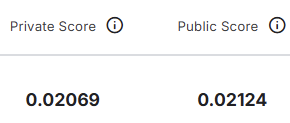

In [ ]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --to html your_notebook.ipynb